In [1]:
import os

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from graspy.utils import import_graph, pass_to_ranks
from graspy.embed import OmnibusEmbed, ClassicalMDS
from graspy.embed.svd import select_dimension
from graspy.cluster import GaussianCluster
from graspy.plot import heatmap, pairplot

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/j1c/graphstats/venv/lib/python3.6/site-packages/graspy/plot/__init__.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


### Loading and handling the data

In [2]:
def import_edgelist(path, nodetype=int, delimiter=None):
    """
    Function for reading an edgelist and returning a numpy array.
    The order of nodes are sorted by node values.

    Parameters
    ----------
    path : str
    delimiter : str, optional
    
    Returns
    -------
    graph : array-like, shape (n_vertices, n_vertices)
        Adjacency matrix of the graph created from edgelist.
    """
    G = nx.read_weighted_edgelist(path, delimiter=delimiter, nodetype=nodetype)
    graph = nx.to_numpy_array(G, nodelist=sorted(G.nodes), dtype=np.float)

    return import_graph(graph)

In [3]:
df = pd.read_csv('./subject_information.csv')

In [4]:
fmri_path = '../HBN/fmri/desikan/'
fmris = os.listdir(fmri_path)

dmri_path = '../HBN/dwi/desikan/'
dmris = os.listdir(dmri_path)

dmri_graphs = []
fmri_graphs = []

for subject in df['Patient_ID'].values:
    dfile = [i for i in dmris if subject in i][0]
    ffile = [i for i in fmris if subject in i][0]
    dmri_graphs.append(import_edgelist(dmri_path + dfile))
    fmri_graphs.append(import_edgelist(fmri_path + ffile))

In [5]:
print(len(fmri_graphs), len(dmri_graphs))

289 289


### Visualizing age distributions and converting to discrete labels

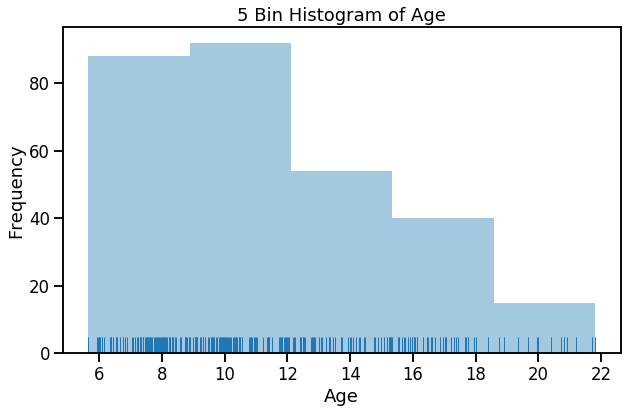

In [6]:
age = df['Age'].values

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.distplot(age, bins=5, kde=False, rug=True)
    plot.set(xlabel='Age', ylabel='Frequency', title='5 Bin Histogram of Age')

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

In [8]:
labeler = KBinsDiscretizer(5)
age_matrix = labeler.fit_transform(age.reshape(-1, 1)).toarray()
#age_labels = np.argmax(age_matrix, axis=1)

labeler.bin_edges_

array([array([ 5.641113 ,  7.959753 ,  9.7255756, 11.865434 , 15.2821122,
       21.816563 ])], dtype=object)

In [9]:
age_labels = []
for age in age_matrix:
    idx = np.argmax(age)
    
    if idx == 0:
        age_labels.append('5.6-8.0')
    elif idx == 1:
        age_labels.append('8.0-9.7')
    elif idx == 2:
        age_labels.append('9.7-11.9')
    elif idx == 3:
        age_labels.append('11.9-15.2')
    else:
        age_labels.append('15.2-21.8')
        
len(age_labels)

289

# Multimodal, multigraph clustering

Data summary
- subjects = 30
- total fmri scans = 289
- total dmri scans = 289
- total scans = 578

Desikan atlas
- num vertices = 70

## KMeans on vectorized data as baseline

1. vectorize the upper triangle for both fmris and dmris
2. concatenate the fmri and dmri vectors for each subject
3. results in matrix in $\mathbb{R}^{289 \times 4970}$
4. run kmeans on the matrix with varying $k$ and compute ARI

In [10]:
idx = np.triu_indices(70)

fmri_vecs = np.vstack([g[idx] for g in fmri_graphs])
dmri_vecs = np.vstack([g[idx] for g in dmri_graphs])
mri_vectors = np.hstack([fmri_vecs, dmri_vecs])

mri_vectors.shape

(289, 4970)

### ARI values show no meaningful clusters
There are 5 labels, based on 5 histogram bins as shown above

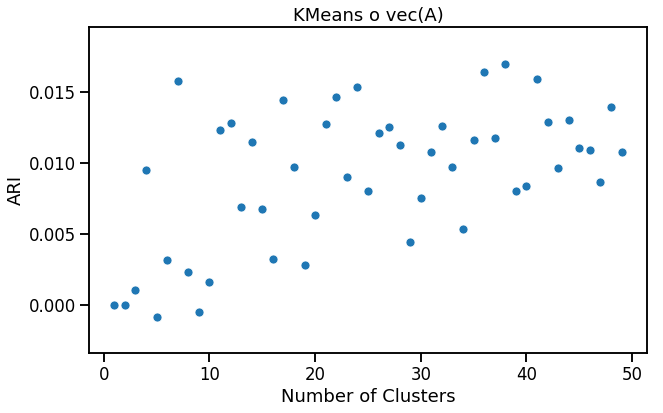

In [11]:
aris = []

for n_clusters in range(1, 50):
    kmeans = KMeans(n_clusters=n_clusters)
    predictions = kmeans.fit_predict(mri_vectors)
    aris.append(adjusted_rand_score(age_labels, predictions))
    
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='KMeans o vec(A)')

## Try with GClust o CMDS o Omni

## Embedding the multimodal graphs all at once and concatenating results from fMRI and DWIs

First we embed graphs from DWIs and fMRIs separately. Then we concatenate the resulting estimated latent position vectors

In [12]:
fmri_graphs = [pass_to_ranks(f) for f in fmri_graphs]
dmri_graphs = [pass_to_ranks(f) for f in dmri_graphs]

In [13]:
omni = OmnibusEmbed(n_elbows=2)
dmri_hat = omni.fit_transform(dmri_graphs)

omni = OmnibusEmbed(n_elbows=2)
fmri_hat = omni.fit_transform(fmri_graphs)

Z_hat = np.hstack([fmri_hat, dmri_hat])
Z_hat.shape

(20230, 7)

In [14]:
Z_hat = Z_hat.reshape((289, 70, -1))
Z_hat.shape

(289, 70, 7)

In [15]:
cmds = ClassicalMDS(n_components=5)
X = cmds.fit_transform(Z_hat)

dissimilarity = cmds.dissimilarity_matrix_

### T-semipar shows block structure based on subjects

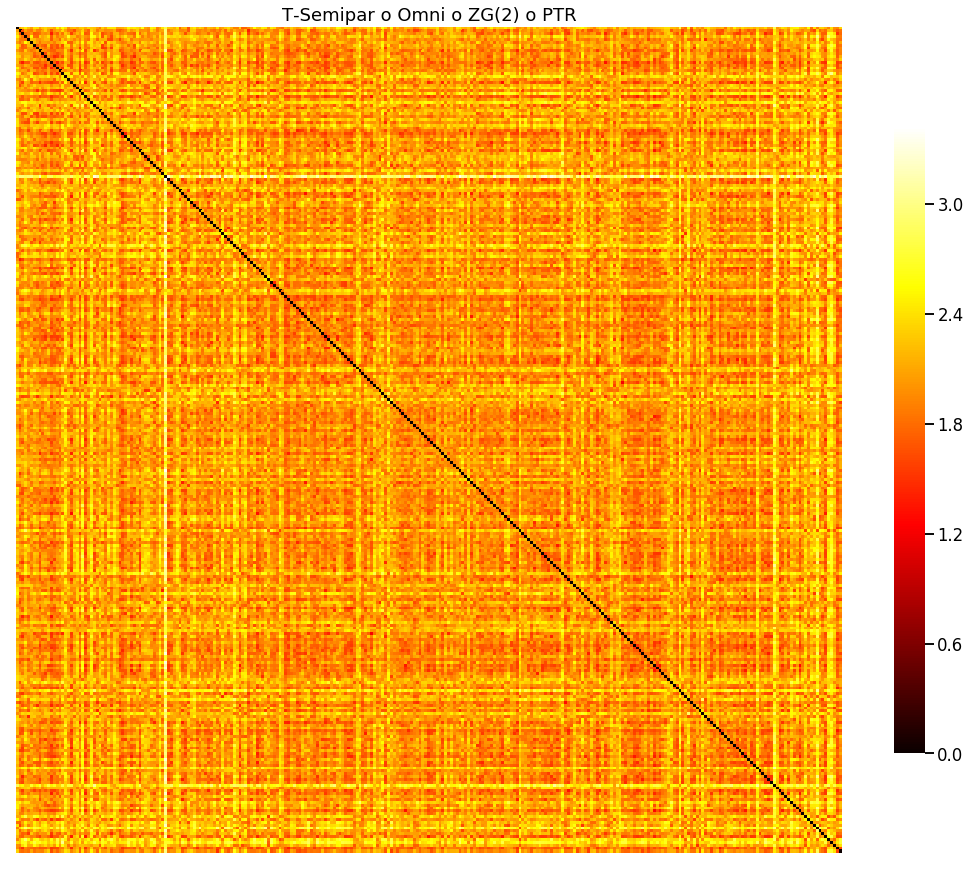

In [16]:
figsize=(15, 13)
title = 'T-Semipar o Omni o ZG(2) o PTR'
semipar = heatmap(dissimilarity, figsize=figsize, title=title, cmap='hot')

### cMDS o T-Semipar o Omni o PTR

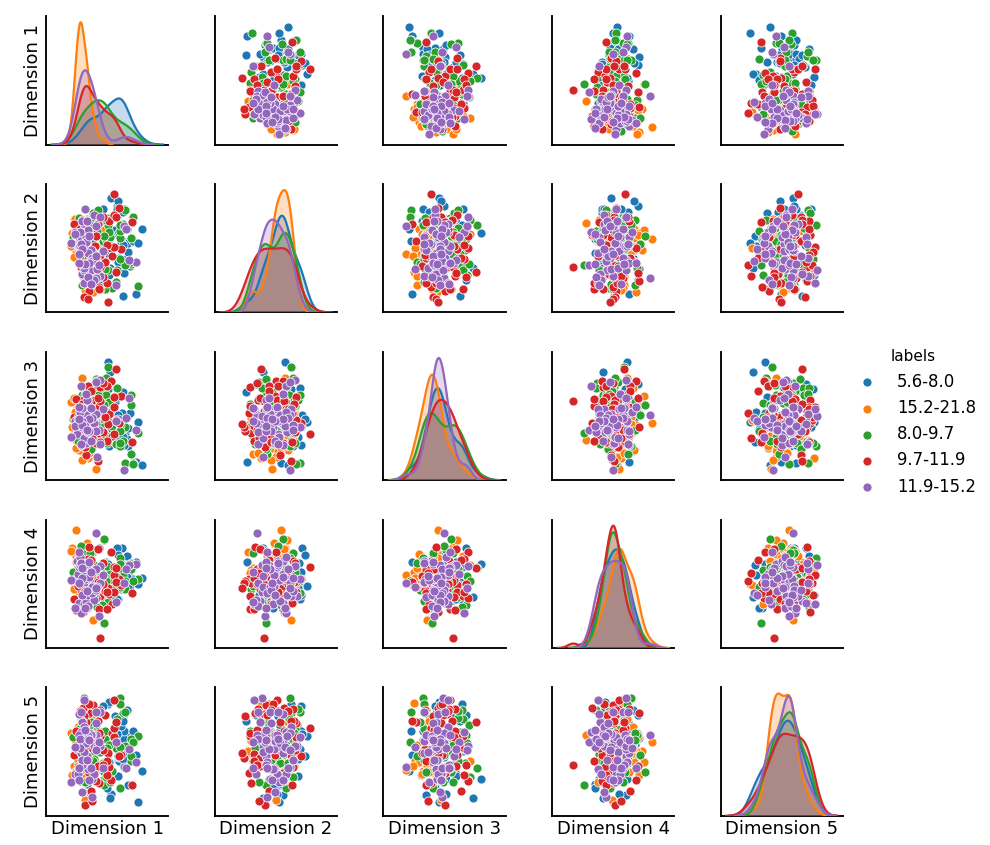

In [17]:
pairplot(np.fliplr(X), labels=age_labels)

### BIC is minimized when num_clusters=2, but ARI suggests no meaningful clusters were found

There are 5 unique labels, each age bin as shown above.

In [18]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, age_labels)

bics = gclust.bic_
print(np.min(bics), np.argmin(bics) + 1)

1423.4121509118922 2


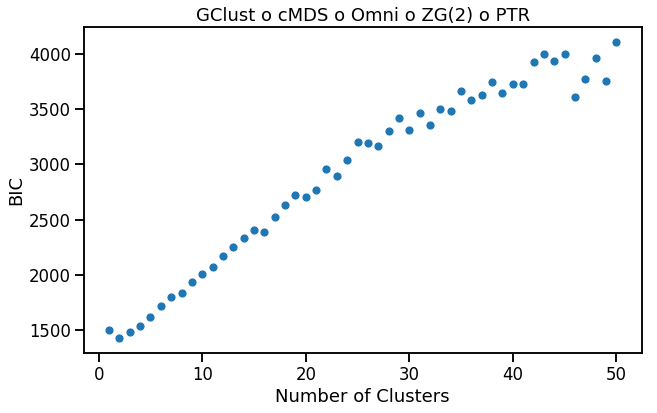

In [19]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) + 1), bics)
    plot.set(xlabel='Number of Clusters', ylabel='BIC', title='GClust o cMDS o Omni o ZG(2) o PTR')

0.12641875341108672 2


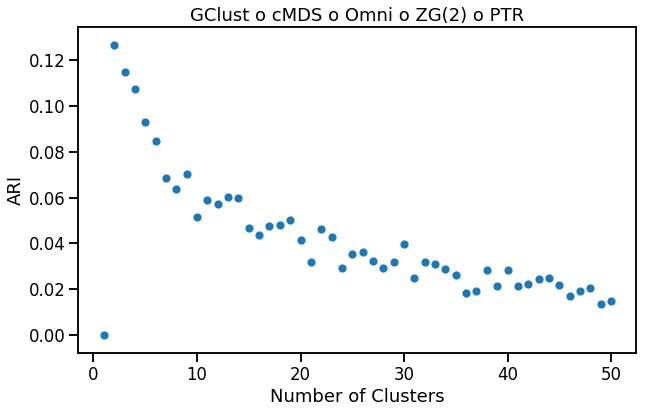

In [20]:
aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o ZG(2) o PTR')

## Look at the pairwise plot from cMDS o T-Semipar o Omni o PTR again

The first dimension seems to show that there are differences among the different age groups. That is as the ages increase, the KDE shifts left with less variance. Lets try clustering with two labels instead where we split the age at $(max - min) / 2$.

(array([208,  81]), array([ 5.641113, 13.728838, 21.816563]))

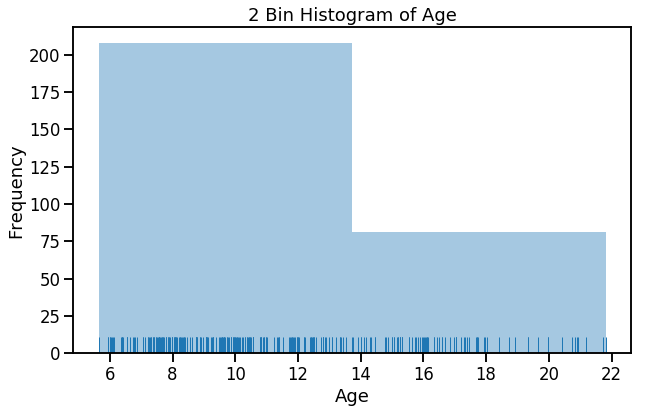

In [21]:
age = df['Age'].values

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.distplot(age, bins=2, kde=False, rug=True)
    plot.set(xlabel='Age', ylabel='Frequency', title='2 Bin Histogram of Age')
    
np.histogram(age, 2)

In [22]:
np.histogram(age, 2)

(array([208,  81]), array([ 5.641113, 13.728838, 21.816563]))

In [23]:
age_labels_2bin = []
for val in age:
    if val < 13.728838:
        age_labels_2bin.append('< 13.72')
    else:
        age_labels_2bin.append('>=13.72')


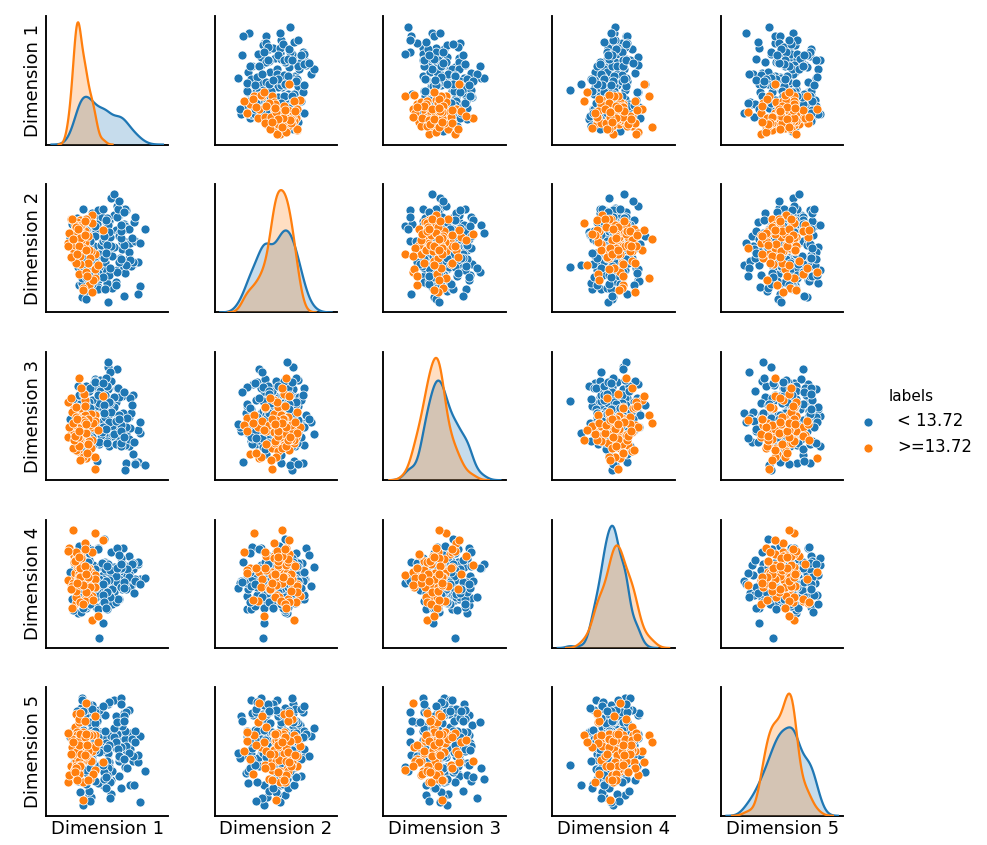

In [24]:
pairplot(np.fliplr(X), labels=age_labels_2bin)

1423.4121509118922 2


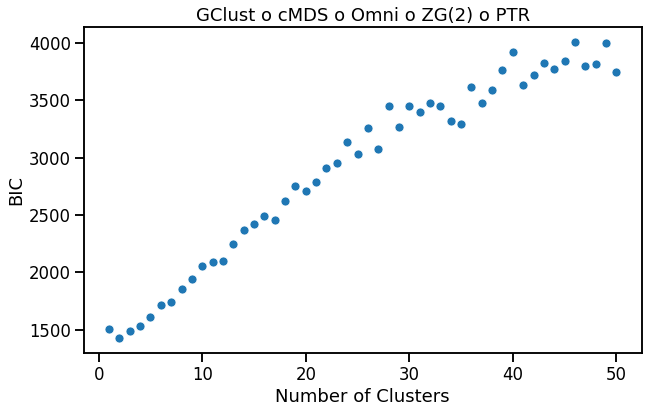

In [25]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, age_labels_2bin)

bics = gclust.bic_
print(np.min(bics), np.argmin(bics) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) + 1), bics)
    plot.set(xlabel='Number of Clusters', ylabel='BIC', title='GClust o cMDS o Omni o ZG(2) o PTR')

0.09227283588661393 2


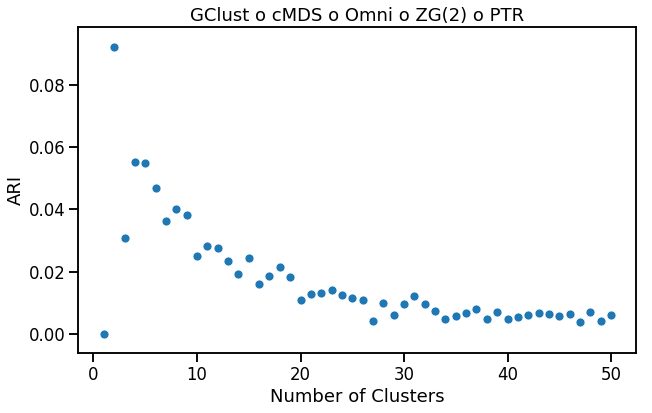

In [26]:
aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o ZG(2) o PTR')

## Try splitting at median instead and then cluster

In [27]:
age = df['Age'].values
median = np.median(age)

In [28]:
age_labels_median = []
for val in age:
    if val < median:
        age_labels_median.append('< Median')
    elif val >= median:
        age_labels_median.append('>= Median')

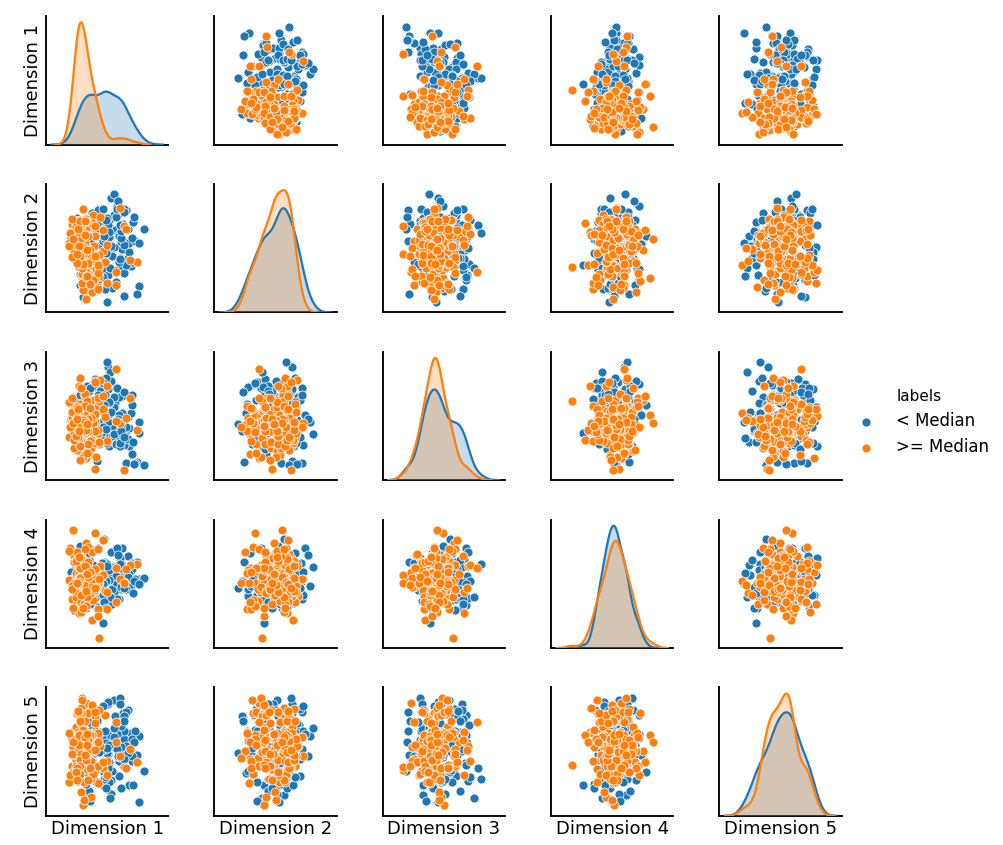

In [29]:
pairplot(np.fliplr(X), labels=age_labels_median)

1424.245163275698 2


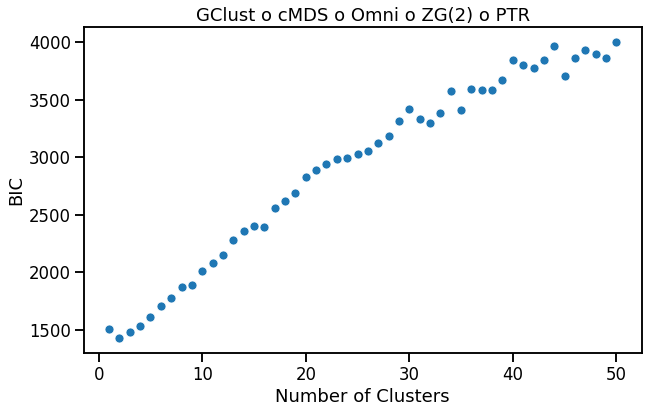

In [30]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, age_labels_median)

bics = gclust.bic_
print(np.min(bics), np.argmin(bics) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) + 1), bics)
    plot.set(xlabel='Number of Clusters', ylabel='BIC', title='GClust o cMDS o Omni o ZG(2) o PTR')

0.270693620900725 2


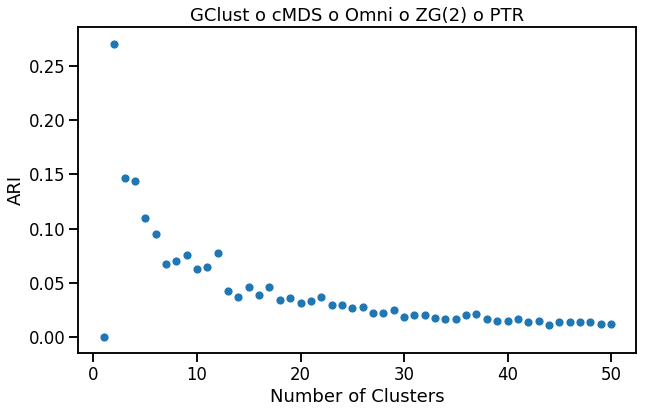

In [31]:
aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o ZG(2) o PTR')